# Разработка модели контекстного перевода сокращений в текстах на русском языке
## 1. Предобработка данных

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import pymorphy2
import nltk
import pickle

from matplotlib import pyplot as plt

from tqdm import tqdm

## Загрузка данных 

In [2]:
abbr_original = pd.read_csv("../data/abbr_dict.csv", sep="\t")
abbr_original

,abbr,desc,tags
0,ТММ,теория механизмов и машин,образование и наука
1,ННИЦ алмазов,Национальный научно-исследовательский центр ал...,"г. Якутск, образование и наука"
2,БВВУ,Бакинское высшее военное училище,"воен., г. Баку, образование и наука"
3,ВНИПИЭТ,Всероссийский научно-исследовательский и проек...,NaN
4,СТЭФ,служба технической эксплуатации флота,техн.
...,...,...,...
85530,КПЦ,Коммунистическая партия Цейлона,Коммунистическая партия Цейлона
85531,ФМП,факультет мировой политики,"<a href=""http://www.worldpolitics.redline.ru/""..."
85532,НИИАТ,Государственный научно-исследовательский инсти...,Государственный научно-исследовательский инсти...
85533,КЗП-,комплекс защиты пласта,


In [3]:
lenta_original = pd.read_csv("../data/lenta-ru-news.csv")
lenta_original

<ipython-input-3-60414ffb7267>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  lenta_original = pd.read_csv("../data/lenta-ru-news.csv")


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


## Предобработка данных 

In [4]:
texts = lenta_original.text.to_list()

In [5]:
abbr = abbr_original.groupby("desc")["abbr"].transform(lambda x: "; ".join(x))
abbr = abbr_original.set_index("desc").T.to_dict()

<ipython-input-5-4d59affa843b>:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  abbr = abbr_original.set_index("desc").T.to_dict()


### Токенизация 

In [28]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
def tokenize(line):
    return tokenizer.tokenize(str(line).lower())

In [7]:
tokenized_texts = list(map(tokenize, texts))

In [8]:
tokenized_abbr = {tuple(tokenize(desc)): tuple(tokenize(values["abbr"])) 
                  for desc, values in abbr.items()}

### Фильтрация данных 

#### Ограничения на длины текстов 

In [9]:
text_sizes = list(map(len, tokenized_texts))

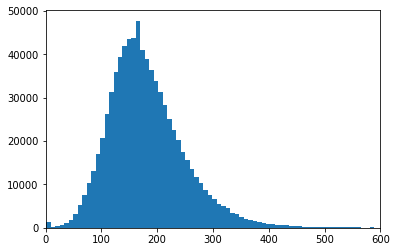

In [10]:
plt.hist(x=text_sizes, bins=1000)

plt.xlim(0, 600)
None

In [11]:
MIN_WORD_IN_SENTENCE = 32
MAX_WORD_IN_SENTENCE = 512

print(f"Original text num: {len(tokenized_texts)}")
tokenized_texts = list(
    filter(lambda x: MIN_WORD_IN_SENTENCE <= len(x) <= MAX_WORD_IN_SENTENCE, 
                             tokenized_texts)
)
print(f"Filtred text num: {len(tokenized_texts)}")

Original text num: 800975
Filtred text num: 796639


#### Ограничения на сокращения 

In [12]:
desc_sizes = list(map(len, tokenized_abbr.keys()))
abbr_sizes = list(map(len, tokenized_abbr.values()))

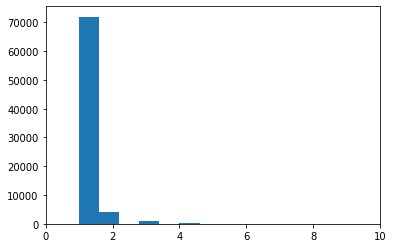

In [13]:
plt.hist(x=abbr_sizes, bins=10)
plt.xlim(0, 10)
None

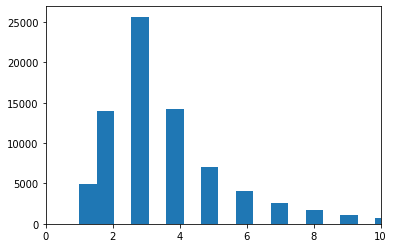

In [14]:
plt.hist(x=desc_sizes, bins=100)
plt.xlim(0, 10)
None

In [15]:
MAX_ABBR_WORD = 1
MAX_DESC_WORD = 4

print(f"Original abbr num: {len(tokenized_abbr)}")
tokenized_abbr = {desc: abbr  
                  for desc, abbr in tokenized_abbr.items() 
                  if len(abbr) <= MAX_ABBR_WORD and len(desc) <= MAX_DESC_WORD}
print(f"Filtred abbr num: {len(tokenized_abbr)}")

Original abbr num: 77206
Filtred abbr num: 56853


### Приведение к нормальной форме 

In [16]:
morph = pymorphy2.MorphAnalyzer(lang="ru")

def get_normal_form(word):
    return morph.parse(str(word))[0].normal_form

tokenized_abbr = {tuple(map(get_normal_form, desc)): abbr[0] 
                  for desc, abbr in tqdm(tokenized_abbr.items())}

100%|██████████| 56853/56853 [00:16<00:00, 3539.84it/s]


In [21]:
batch_size = 100000
i = 0

while True:
    l, r = batch_size * i, batch_size * (i + 1)
    if l >= len(tokenized_texts):
        break
    
    tokenized_texts_batch = [list(map(get_normal_form, text)) 
                              for text in tqdm(tokenized_texts[l:r])]
    
    with open(f'../data/tokenized_texts_part_{i}.pickle', 'wb') as f:
        pickle.dump(tokenized_texts_batch, f)
    
    i += 1

100%|██████████| 96639/96639 [23:36<00:00, 68.24it/s]


In [13]:
tokenized_text = []
for part_path in filter(lambda x: "part" in x, os.listdir("../data")):
    with open(os.path.join("../data", part_path), "rb") as f:
        part = pickle.load(f)
    tokenized_text.extend(part)

In [16]:
with open('../data/tokenized_texts.pickle', 'wb') as f:
    pickle.dump(tokenized_text, f)

In [19]:
! rm ../data/tokenized_texts_part_*

## Сохранение 

In [19]:
with open('../data/tokenized_abbr.pickle', 'wb') as f:
    pickle.dump(tokenized_abbr, f)